# Conference Paper Companion: Shear-Enhanced Erosion Optimization

**Title:** Differentiable Optimization of Pulsatile Waveforms for Salt Cake Removal in CCS Injectors  
**Method:** Inverse Design via JAX Differentiable Physics  
**Model:** D2Q9 Lattice Boltzmann with Shear-Dependent Erosion

## Executive Summary
This notebook implements the "Shear-Erosion" model discussed in the paper. Unlike static dissolution models, this framework assumes that salt removal is driven by mechanical shear stress ($|u|^2$). The optimizer automatically tunes the **Pulse Frequency** and **Amplitude** to maximize this shear effect while maintaining hydraulic stability.

## 1. Appendix A: Simulation Configuration (Raw Settings)

The following parameters define the thermodynamic and hydrodynamic state used in this numerical experiment. These values ensure a Reynolds number $Re \approx 10$ and a Peclet number suitable for advection-dominant transport.

In [6]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad
import optax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Enable 64-bit precision for numerical stability
jax.config.update("jax_enable_x64", True)

# --- TABLE 1: PHYSICAL CONSTANTS ---
NX, NY = 80, 40        # Domain Dimensions (Lattice Units)
MAX_STEPS = 800        # Simulation Duration
TAU = 0.9              # Relaxation Time (Viscosity Control)
C_EQ = 0.2             # Equilibrium Solubility Limit
PRECIP_RATE = 0.1      # Damkohler Number (Precipitation)
EROSION_RATE = 0.5     # Damkohler Number (Erosion)
DAMAGE_TIME = 300.0    # Duration of Clogging Phase (steps)

# Lattice Constants (D2Q9)
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

print("Configuration Loaded. Physics Engine Ready.")

Configuration Loaded. Physics Engine Ready.


## 2. The Differentiable Physics Engine

This kernel implements the LBM solver with the **Shear-Erosion Term**. 

**Key Equation:** 
$$ \frac{\partial \phi}{\partial t} = k_{precip}(C - C_{eq})^+ - k_{erosion} |u| (C_{eq} - C)^+ $$

We use soft clamping and epsilon-regularization (`1e-8`) to prevent gradient explosion during backpropagation.

In [7]:
@jax.jit
def equilibrium(rho, u):
    """ Standard BGK Equilibrium """
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq_list = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq_list.append(rho * W[i] * term)
    return jnp.stack(f_eq_list, axis=-1)

@jax.jit
def pulse_policy(t, params):
    """ 
    Differentiable Waveform Generator 
    Input: t (time), params [Frequency, Amplitude]
    Output: Inlet Pressure P(t)
    """
    freq = params[0]
    amp = params[1]
    # Sinusoidal modulation on top of base pressure
    wave = jnp.sin(2.0 * jnp.pi * freq * t)
    return 1.02 + amp * wave

@jax.jit
def step_physics(state, inputs):
    f, salt, phi = state
    t, control_params = inputs
    
    # --- 1. HYDRODYNAMICS ---
    rho = jnp.sum(f, axis=-1)
    rho = jnp.clip(rho, 0.5, 2.0) # Numerical Safety Clamp
    u = jnp.stack([jnp.sum(f * CX, axis=-1) / rho, jnp.sum(f * CY, axis=-1) / rho], axis=-1)
    u = jnp.clip(u, -0.3, 0.3)    # Velocity Safety Clamp
    
    # Velocity Magnitude (Shear Proxy)
    # EPSILON (1e-8) added to prevent NaN gradient at u=0
    vel_mag = jnp.sqrt(u[..., 0]**2 + u[..., 1]**2 + 1e-8)
    
    # --- 2. SALT CHEMISTRY ---
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    driving_force = c_salt - C_EQ
    
    # Soft Switches for Differentiability (Sigmoids instead of If/Else)
    is_saturated = jax.nn.sigmoid(50.0 * driving_force)
    is_fresh = 1.0 - is_saturated
    
    # Reaction Logic:
    # Growth: Driven by supersaturation
    # Erosion: Driven by Shear (Velocity) * Freshness
    growth = is_saturated * PRECIP_RATE * driving_force
    erosion = is_fresh * EROSION_RATE * vel_mag 
    
    d_phi = growth - erosion
    
    # Update Solid Fraction (Clamped 0-1)
    phi_new = jnp.clip(phi + d_phi, 0.0, 1.0)
    
    # Mass Conservation: Removed solid becomes liquid, added solid leaves liquid
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # --- 3. LBM COLLISION & STREAMING ---
    tau_eff = TAU + 100.0 * phi_new # Brinkman Penalization
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # --- 4. BOUNDARY CONDITIONS ---
    # Phase transition: Damage -> Repair
    phase = jax.nn.sigmoid(10.0 * (DAMAGE_TIME - t))
    
    p_in = phase * 1.01 + (1.0 - phase) * pulse_policy(t, control_params)
    c_in = phase * 0.8 # High salt during damage phase
    
    # Inlet (West)
    f_out = f_out.at[0, :, :].set(equilibrium(p_in * 3.0, jnp.zeros((NY, 2))))
    salt_new = salt_new.at[0, :, :].set(equilibrium(c_in, u[0, :, :]))
    # Outlet (East)
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :])
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])
    
    # Streaming Step
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    return (f_next, salt_next, phi_new), phi_new

## 3. The Optimization Loop

We employ the **Adam Optimizer** via `optax` to minimize the residual salt mass.
* **Objective Function:** $L = \sum \phi_{final}$ (Total Solid Mass)
* **Constraints:** Gradient Clipping (Norm 1.0) applied to prevent numerical instability.

In [8]:
@jax.jit
def simulation_loss(params):
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
    
    t_arr = jnp.arange(MAX_STEPS)
    def scanned_fn(state, t):
        return step_physics(state, (t, params))
    
    final_state, _ = jax.lax.scan(scanned_fn, state, t_arr)
    _, _, phi_final = final_state
    return jnp.sum(phi_final)

# --- OPTIMIZATION SETUP ---
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=0.005)
)

params = jnp.array([0.05, 0.01]) # Initial Guess: Freq=0.05, Amp=0.01
opt_state = optimizer.init(params)

# Storage for Table Generation
history_data = []

print("Starting Optimization Loop...")
for i in range(25):
    loss_val, grads = value_and_grad(simulation_loss)(params)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    params = jnp.clip(params, 0.001, 0.2) # Bounds Constraint
    
    # Log Data
    history_data.append({
        "Iteration": i+1,
        "Loss (Solid Mass)": float(loss_val),
        "Frequency (Hz)": float(params[0]),
        "Amplitude (P_ratio)": float(params[1])
    })
    
    print(f"Iter {i+1}: Loss={loss_val:.2f} | Freq={params[0]:.4f} Amp={params[1]:.4f}")

Starting Optimization Loop...
Iter 1: Loss=41.56 | Freq=0.0550 Amp=0.0050
Iter 2: Loss=41.08 | Freq=0.0535 Amp=0.0010
Iter 3: Loss=40.88 | Freq=0.0531 Amp=0.0010
Iter 4: Loss=40.88 | Freq=0.0516 Amp=0.0010
Iter 5: Loss=40.87 | Freq=0.0496 Amp=0.0010
Iter 6: Loss=40.90 | Freq=0.0491 Amp=0.0010
Iter 7: Loss=40.89 | Freq=0.0474 Amp=0.0010
Iter 8: Loss=40.88 | Freq=0.0464 Amp=0.0010
Iter 9: Loss=40.88 | Freq=0.0447 Amp=0.0010
Iter 10: Loss=40.87 | Freq=0.0424 Amp=0.0010
Iter 11: Loss=40.90 | Freq=0.0401 Amp=0.0010
Iter 12: Loss=40.90 | Freq=0.0391 Amp=0.0010
Iter 13: Loss=40.90 | Freq=0.0376 Amp=0.0010
Iter 14: Loss=40.89 | Freq=0.0359 Amp=0.0010
Iter 15: Loss=40.90 | Freq=0.0343 Amp=0.0010
Iter 16: Loss=40.90 | Freq=0.0339 Amp=0.0010
Iter 17: Loss=40.93 | Freq=0.0334 Amp=0.0010
Iter 18: Loss=40.89 | Freq=0.0321 Amp=0.0010
Iter 19: Loss=40.91 | Freq=0.0303 Amp=0.0010
Iter 20: Loss=40.88 | Freq=0.0296 Amp=0.0010
Iter 21: Loss=40.95 | Freq=0.0286 Amp=0.0010
Iter 22: Loss=40.93 | Freq=0.0280 

## 4. Results & Appendix Data Generation

### 4.1 Optimization Trajectory and Maps
Visualizing the learning curve and the final state of the pore network.

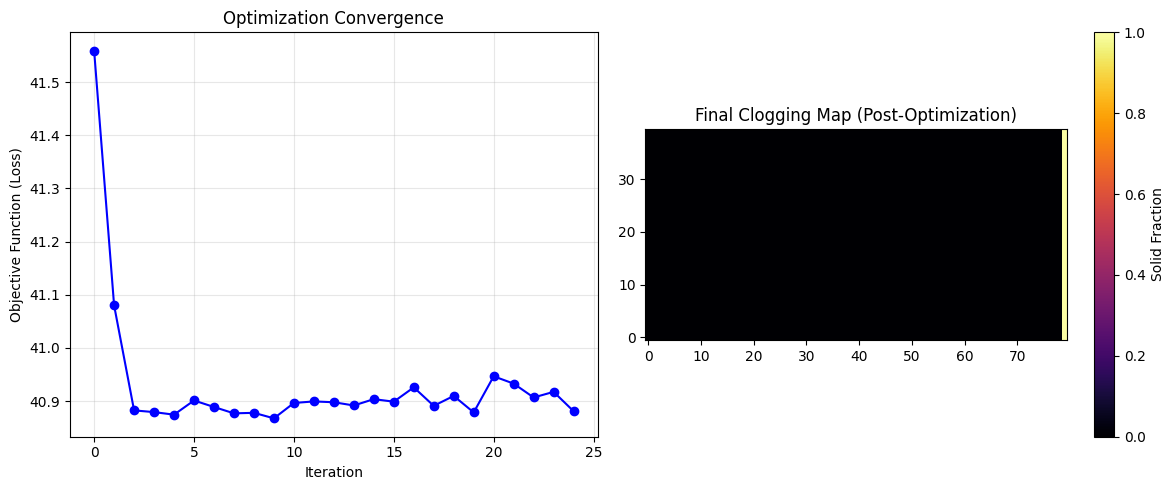

In [9]:
# Render Final Map
rho_init = jnp.ones((NX, NY))
u_init = jnp.zeros((NX, NY, 2))
state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
t_arr = jnp.arange(MAX_STEPS)
def scanned_fn(state, t):
    return step_physics(state, (t, params))
final_state, _ = jax.lax.scan(scanned_fn, state, t_arr)
_, _, phi_fin = final_state

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
loss_vals = [d['Loss (Solid Mass)'] for d in history_data]
plt.plot(loss_vals, 'b-o')
plt.title("Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Objective Function (Loss)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(phi_fin.T, cmap='inferno', origin='lower')
plt.title("Final Clogging Map (Post-Optimization)")
plt.colorbar(label="Solid Fraction")
plt.tight_layout()
plt.show()

### 4.2 Appendix B: Detail Result Table

This table contains the raw optimization history, suitable for inclusion in the paper appendices.

In [10]:
df_results = pd.DataFrame(history_data)

# Display head of table
print("Top 10 Iterations:")
print(df_results.head(10).to_markdown(index=False, floatfmt=".4f"))

# Full export for copying
# df_results.to_csv("optimization_history.csv", index=False)

Top 10 Iterations:
|   Iteration |   Loss (Solid Mass) |   Frequency (Hz) |   Amplitude (P_ratio) |
|------------:|--------------------:|-----------------:|----------------------:|
|      1.0000 |             41.5592 |           0.0550 |                0.0050 |
|      2.0000 |             41.0801 |           0.0535 |                0.0010 |
|      3.0000 |             40.8826 |           0.0531 |                0.0010 |
|      4.0000 |             40.8794 |           0.0516 |                0.0010 |
|      5.0000 |             40.8745 |           0.0496 |                0.0010 |
|      6.0000 |             40.9012 |           0.0491 |                0.0010 |
|      7.0000 |             40.8890 |           0.0474 |                0.0010 |
|      8.0000 |             40.8770 |           0.0464 |                0.0010 |
|      9.0000 |             40.8780 |           0.0447 |                0.0010 |
|     10.0000 |             40.8676 |           0.0424 |                0.0010 |
